# Corona - German mortality and vaccination timeseries

## Data sources:

1. Mortality statistics for the years 2000 to 2015: [de_statis: Deutschland Sterbefälle 2000-2015](https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Sterbefaelle-Lebenserwartung/Tabellen/sonderauswertung-sterbefaelle-endgueltige-daten.html;jsessionid=7C42BA66C2036FF4141E5AC46AD386D5.live712?nn=209016)
2. Mortality statistics for the years 2016 to 2022 (Aug 21): [de_statis: Deutschland Sterbefälle 2016-2022 ](https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Sterbefaelle-Lebenserwartung/Tabellen/sonderauswertung-sterbefaelle.html)
3. Vaccination statistics from 2020 onwards: [impfdashboard.de - Daten zum Downlad](https://impfdashboard.de/daten)


rough outline of the next steps:

1. import the mortality data as a continuous week based time series beginning with the first week of 2010 as index week 1
    - import the data based on maximum granularity regarding sex and age group (done)
    - compose aggregating views (cancelled)


2. import the vaccination data as continuous week based time series
    - get acquainted with the data model (done)
    

3. go and find people already doing analysis on the data, esp. 
    - go and explain this finding: [Starker (negativer) statistischer Zusammenhang zwischen der Covid-19-Impfquote und der Übersterblichkeit](https://idw-online.de/de/news786629)
    - German statistics computes excess mortality as the difference between the median value for the same timeframes of the four previous years: [WHO-Studie zur Corona-Übersterblichkeit nutzt störanfällige Methode](https://www.rwi-essen.de/presse/wissenschaftskommunikation/unstatistik/detail/who-studie-zur-corona-uebersterblichkeit-nutzt-stoeranfaellige-methode)




## Data preparation and first exploration

1. Aligning the data to a common time frame

The mortality data comes week based, the "Impfdashboard" file gives daily numbers. The first steps here are

- aggregation of the vaccination data to a weekly basis
- aligning the week index so that it references the week from the 04th of January 2010, the origin week of the mortality file
- normalize relevant variables to z-scores of themselves to avoid graphical clutter in the plots

2. Join the data and cut the mortality data off at the week of December 28th, 2020 - the beginning of the vaccination campaign

In [1]:
# import requirements

import pandas as pd
import pprint
import statistics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure as fig
#import seaborn as sns
#sns.set_theme(style="darkgrid")

In [2]:
# import mortality data and calculate excess and differential

sterbefaelle = pd.read_csv('../data/deaths/sterbefaelle-2010-2022-je-woche.csv', delimiter=';')

# calculate excess mortality per week following the difference between actual data point 
# and "median of the four prior corresponding data points" methond of  de_statis

i = 0
for x in sterbefaelle.iterrows():    
    sterbefaelle.iloc[3,10]
    if sterbefaelle.loc[i,"week_index"] >= 209:
        sterbefaelle.loc[i,"total_median"] = statistics.median([sterbefaelle["total"][i-208],sterbefaelle["total"][i-156],sterbefaelle["total"][i-104],sterbefaelle["total"][i-52]])
        sterbefaelle.loc[i,"total_excess"] = sterbefaelle["total"][i] - sterbefaelle["total_median"][i]   
    else:
        sterbefaelle["total_median"] = 0
        sterbefaelle["total_excess"] = 0
        
    if sterbefaelle.loc[i,"week_index"] >= 210:  
        sterbefaelle.loc[i,"total_median_diff"]       = 1 - (sterbefaelle["total_median"][i]/sterbefaelle["total_median"][i-1])  
        sterbefaelle.loc[i,"total_excess_diff"]       = 1 - (sterbefaelle["total_excess"][i]/sterbefaelle["total_excess"][i-1])
    else: 
        sterbefaelle.loc[i,"total_median_diff"] = 0
        sterbefaelle.loc[i,"total_excess_diff"] = 0
    
    i = i+1


In [3]:
# import vaccination data 

vaccinations = pd.read_csv('../data/vaccinations/germany_vaccinations_timeseries_v3.tsv', sep='\t')
#vaccinations
vax_columns = [
    'week_index',       # added preemptively for the next step of aggregating data on a weekly basis
    'impfungen',
    'impfungen_biontech',
    'impfungen_biontech_min1',
    'impfungen_biontech_gi',
    'impfungen_biontech_boost1',
    'impfungen_biontech_boost2',
    'impfungen_moderna',
    'impfungen_moderna_min1',
    'impfungen_moderna_gi',
    'impfungen_moderna_boost1',
    'impfungen_moderna_boost2',
    'impfungen_astra',
    'impfungen_astra_min1',
    'impfungen_astra_gi',
    'impfungen_astra_boost1',
    'impfungen_astra_boost2',
    'impfungen_johnson',
    'impfungen_johnson_min1',
    'impfungen_johnson_gi',
    'impfungen_johnson_boost1',
    'impfungen_johnson_boost2',
    'impfungen_novavax',
    'impfungen_novavax_min1',
    'impfungen_novavax_gi',
    'impfungen_novavax_boost1',
    'impfungen_novavax_boost2',
    'personen_min1',
    'impfungen_min1',
    'personen_gi',
    'impfungen_gi',
    'personen_boost1',
    'impfungen_boost1',
    'personen_boost2',
    'impfungen_boost2',
    ]


In [4]:
# extract data from mortality and vaccination sources for the identical timeframe
# the mortality data date range ends with the week from 15th to 21st of August 2022
# this is 86 weeks overlap with the vaccination data.
# For conversion to weekly data the 1st through 602nd rows of the dataframe are grouped


# 1. convert vaccination data to weekly

i = 0
j = 573

for row in vaccinations.iterrows():
    vaccinations.loc[i,"day_index"] = i
    vaccinations.loc[i,"week_index"] = j
    i = i+1
    if i % 7 == 1:
        j = j+1

vax_weekly = vaccinations[vax_columns][1:602].groupby(by="week_index").sum()
vax_weekly.reindex(columns=["week_index","impfungen","impfungen_lag"])



# 2. extract the corresponding part from the mortality data

deaths_list = ["week_index", "monday", "total", "total_excess"]
deaths_weekly = sterbefaelle[deaths_list]
#print(deaths_weekly)


# 3. merge the timeseries to one dataframe. 
# Merge using the default method of inner join.

death_vax_weekly = deaths_weekly.merge(vax_weekly, left_on='week_index', right_on='week_index')#, how='left')
#print(death_vax_weekly)


# 4. create additional variables for combined first and second shots of Pfizer / Biontech
# combined first and second shots of Pfizer / Biontech:
death_vax_weekly["impfungen_biontech_min1_gi"] = (death_vax_weekly["impfungen_biontech_min1"] + death_vax_weekly["impfungen_biontech_gi"])


# 4. calculate the z-scores of the variables "total deaths", "total excess deaths" and "vaccinations (impfungen)"
z_score_list   = ["total","total_excess","impfungen","impfungen_biontech_min1_gi"]
total_mean = death_vax_weekly[z_score_list].mean()
total_std  = death_vax_weekly[z_score_list].std()
death_vax_weekly["total_z"]     = (death_vax_weekly["total"]-total_mean[0])/total_std[0]
death_vax_weekly["total_excess_z"]    = (death_vax_weekly["total_excess"]-total_mean[1])/total_std[1]
death_vax_weekly["impfungen_z"] = (death_vax_weekly["impfungen"]-total_mean[2])/total_std[2]
death_vax_weekly["impfungen_biontech_min1_gi_z"] = (death_vax_weekly["impfungen_biontech_min1_gi"]-total_mean[3])/total_std[3]
#print(death_vax_weekly)

# 5. create a lagged vaccination curve by shifting the data points 23 weeks ahead.
# See https://jdee.substack.com/p/vaccines-and-death-part-1
death_vax_weekly["impfungen_biontech_min1_gi_lag"] = death_vax_weekly["impfungen_biontech_min1_gi"].shift(23)
# and do the same for the z-score
death_vax_weekly["impfungen_biontech_min1_gi_z_lag"] = death_vax_weekly["impfungen_biontech_min1_gi_z"].shift(23)
# shift the total vaccinations and their z-score, too, for good measure
death_vax_weekly["impfungen_lag"] = death_vax_weekly["impfungen"].shift(23)
death_vax_weekly["impfungen_z_lag"] = death_vax_weekly["impfungen_z"].shift(23)
# and for simplicity shift the excess death to -23 weeks
death_vax_weekly["total_excess_lead"] = death_vax_weekly["total_excess"].shift(-23)
#print(death_vax_weekly)


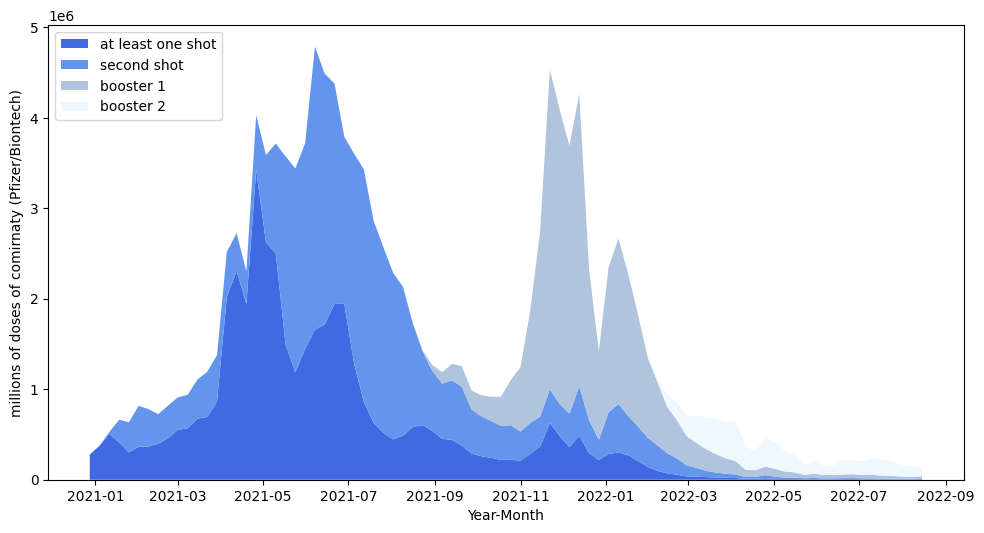

In [12]:
# plot the vaccination campaigns as stacked area chart

# define size of plot
cm = 1/2.54  # centimeters in inches

fig = plt.figure(figsize=(30*cm, 15*cm))        # an empty figure with no Axes
ax1 = plt.subplot()

nobs = len(death_vax_weekly['total_excess'])
dates = pd.date_range("2020-12-28", freq="W-MON", periods=nobs)
index = list(range(1,nobs+1))


# Create data
x=dates
y1=death_vax_weekly["impfungen_biontech_min1"]
y2=death_vax_weekly["impfungen_biontech_gi"]
y3=death_vax_weekly["impfungen_biontech_boost1"]
y4=death_vax_weekly["impfungen_biontech_boost2"]

# Basic stacked area chart.
plt.stackplot(x,y1, y2, y3, y4, labels=['at least one shot','second shot','booster 1','booster 2'], colors=['royalblue','cornflowerblue','lightsteelblue','aliceblue'])
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('millions of doses of comirnaty (Pfizer/Biontech)')
plt.legend(loc='upper left')


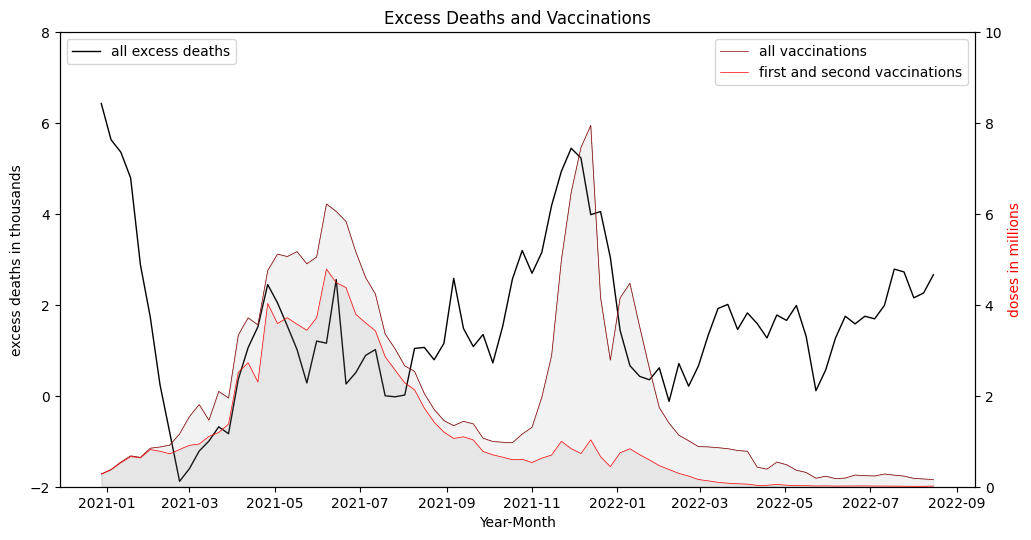

In [24]:
# plot mortality, vaccinations and excess mortality by numeric value

# define size of plot
cm = 1/2.54  # centimeters in inches
fig, ax1 = plt.subplots(figsize=(30*cm, 15*cm))

# define the plot
plt.title('Excess Deaths and Vaccinations')


# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx() 
ax1.set_ylim(-2,8)
ax2.set_ylim(0,10)
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('excess deaths in thousands')
ax2.set_ylabel('doses in millions', color = 'red')

# define data
week_index = death_vax_weekly["week_index"]
total_excess = death_vax_weekly["total_excess"]/1000
impfungen = death_vax_weekly["impfungen"]/1000000
impfungen_lag = death_vax_weekly["impfungen_lag"]/1000000
impfungen_biontech_min1_gi = death_vax_weekly["impfungen_biontech_min1_gi"]/1000000
impfungen_biontech_min1_gi_lag = death_vax_weekly["impfungen_biontech_min1_gi_lag"]/1000000

plt.fill_between(dates, impfungen, color="grey", alpha=0.1)
plt.fill_between(dates, impfungen_biontech_min1_gi, color="grey", alpha=0.1)

ax1.plot(dates, total_excess, color = 'k', linewidth = 1, label='all excess deaths')
ax2.plot(dates, impfungen, color = 'grey', linewidth = 0.5, linestyle = ':')
ax2.plot(dates, impfungen, color = 'darkred', linewidth = 0.5, label='all vaccinations')
ax2.plot(dates, impfungen_biontech_min1_gi, color = 'red', linewidth = 0.5, label='first and second vaccinations')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')


In [38]:
with pd.option_context('display.max_rows', None):
    display(death_vax_weekly)

,week_index,monday,total,total_excess,impfungen,impfungen_biontech,impfungen_biontech_min1,impfungen_biontech_gi,impfungen_biontech_boost1,impfungen_biontech_boost2,impfungen_moderna,impfungen_moderna_min1,impfungen_moderna_gi,impfungen_moderna_boost1,impfungen_moderna_boost2,impfungen_astra,impfungen_astra_min1,impfungen_astra_gi,impfungen_astra_boost1,impfungen_astra_boost2,impfungen_johnson,impfungen_johnson_min1,impfungen_johnson_gi,impfungen_johnson_boost1,impfungen_johnson_boost2,impfungen_novavax,impfungen_novavax_min1,impfungen_novavax_gi,impfungen_novavax_boost1,impfungen_novavax_boost2,personen_min1,impfungen_min1,personen_gi,impfungen_gi,personen_boost1,impfungen_boost1,personen_boost2,impfungen_boost2,impfungen_biontech_min1_gi,total_z,total_excess_z,impfungen_z,impfungen_biontech_min1_gi_z,impfungen_biontech_min1_gi_lag,impfungen_biontech_min1_gi_z_lag,impfungen_lag,impfungen_z_lag,total_excess_lead
0,574,28.12.20,25541,6428.5,278148,278111,278111,0,0,0,27,27,0,0,0,6,6,0,0,0,4,4,0,0,0,0,0,0,0,0,278148,278148,0,0,0,0,0,0,278111,2.877914,2.932276,-0.936739,-0.656536,NaN,NaN,NaN,NaN,1156.5
1,575,04.01.21,24919,5630.0,376170,376039,376039,0,0,0,101,101,0,0,0,10,10,0,0,0,20,20,0,0,0,0,0,0,0,0,376170,376170,0,0,0,0,0,0,376039,2.571843,2.446276,-0.887543,-0.581607,NaN,NaN,NaN,NaN,2556.0
2,576,11.01.21,24532,5357.0,542486,527871,508565,19306,0,0,14581,14575,6,0,0,29,29,0,0,0,5,5,0,0,0,0,0,0,0,0,523174,523174,19312,19312,0,0,0,0,527871,2.381410,2.280117,-0.804072,-0.465432,NaN,NaN,NaN,NaN,260.0
3,577,18.01.21,24129,4791.0,679185,662634,413649,248985,0,0,16464,16441,23,0,0,85,84,1,0,0,2,2,0,0,0,0,0,0,0,0,430176,430176,249009,249009,0,0,0,0,662634,2.183104,1.935626,-0.735465,-0.362318,NaN,NaN,NaN,NaN,508.5
4,578,25.01.21,22674,2881.0,645440,636249,303204,333045,0,0,9083,8957,126,0,0,102,100,2,0,0,6,6,0,0,0,0,0,0,0,0,312267,312267,333173,333173,0,0,0,0,636249,1.467134,0.773122,-0.752401,-0.382507,NaN,NaN,NaN,NaN,888.0
5,579,01.02.21,21773,1739.5,846582,817320,364953,452367,0,0,29126,28963,163,0,0,129,127,2,0,0,7,7,0,0,0,0,0,0,0,0,394050,394050,452532,452532,0,0,0,0,817320,1.023774,0.078359,-0.651451,-0.243960,NaN,NaN,NaN,NaN,1016.5
6,580,08.02.21,20946,244.0,874331,779990,366671,413319,0,0,34056,22301,11755,0,0,60273,59818,455,0,0,12,12,0,0,0,0,0,0,0,0,448802,448802,425529,425529,0,0,0,0,779990,0.616828,-0.831863,-0.637525,-0.272524,NaN,NaN,NaN,NaN,-0.5
7,581,15.02.21,20493,-814.5,915799,724557,398905,325652,0,0,46090,29104,16986,0,0,145119,144856,263,0,0,33,33,0,0,0,0,0,0,0,0,572898,572898,342901,342901,0,0,0,0,724557,0.393918,-1.476110,-0.616713,-0.314938,NaN,NaN,NaN,NaN,-22.5
8,582,22.02.21,18979,-1881.0,1161433,818851,458687,360164,0,0,47873,38467,9406,0,0,294700,294504,196,0,0,9,9,0,0,0,0,0,0,0,0,791667,791667,369766,369766,0,0,0,0,818851,-0.351084,-2.125225,-0.493433,-0.242789,NaN,NaN,NaN,NaN,16.0
9,583,01.03.21,18455,-1605.0,1541187,910706,551753,358953,0,0,78538,51729,26809,0,0,551940,551557,383,0,0,3,3,0,0,0,0,0,0,0,0,1155042,1155042,386145,386145,0,0,0,0,910706,-0.608932,-1.957240,-0.302841,-0.172506,NaN,NaN,NaN,NaN,1041.0
